In [2]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json

def analyze_video_file(video_path):
    """
    Analyze a single video file and extract key characteristics.
    
    Returns:
        dict: Video characteristics including duration, fps, resolution, file size
    """
    try:
        # Open video file
        cap = cv2.VideoCapture(str(video_path))
        
        if not cap.isOpened():
            print(f"Warning: Could not open {video_path}")
            return None
        
        # Get video properties
        fps = float(round(cap.get(cv2.CAP_PROP_FPS)))
        frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        
        # Calculate duration
        duration = frame_count / fps if fps > 0 else 0
        
        # Get file size
        file_size = os.path.getsize(video_path) / (1024 * 1024)  # Size in MB
        
        cap.release()
        
        return {
            'filename': video_path.name,
            'duration_sec': duration,
            'fps': fps,
            'width': width,
            'height': height,
            'resolution': f"{width}x{height}",
            'frame_count': frame_count,
            'file_size_mb': file_size,
            'aspect_ratio': width / height if height > 0 else 0
        }
        
    except Exception as e:
        print(f"Error processing {video_path}: {e}")
        return None

def analyze_video_dataset(folder_path):
    """
    Analyze all video files in a folder and return comprehensive statistics.
    
    Args:
        folder_path (str): Path to folder containing video files
        
    Returns:
        pd.DataFrame: DataFrame with video characteristics
    """
    # Common video extensions
    video_extensions = {'.mp4', '.avi', '.mov', '.mkv', '.wmv', '.flv', '.webm', '.m4v'}
    
    folder = Path(folder_path)
    video_files = [f for f in folder.iterdir() 
                   if f.is_file() and f.suffix.lower() in video_extensions]
    
    print(f"Found {len(video_files)} video files")
    
    # Analyze each video
    results = []
    for i, video_file in enumerate(video_files):
        # print(f"Processing {i+1}/{len(video_files)}: {video_file.name}")
        stats = analyze_video_file(video_file)
        if stats:
            results.append(stats)
    
    return pd.DataFrame(results)

def generate_statistics_report(df):
    """
    Generate comprehensive statistics report from video DataFrame.
    """
    print("=" * 60)
    print("VIDEO DATASET STATISTICS REPORT")
    print("=" * 60)
    
    # Basic counts
    print(f"\nDATASET OVERVIEW:")
    print(f"Total videos: {len(df)}")
    print(f"Total size: {df['file_size_mb'].sum():.1f} MB ({df['file_size_mb'].sum()/1024:.1f} GB)")
    print(f"Total duration: {df['duration_sec'].sum():.1f} seconds ({df['duration_sec'].sum()/3600:.1f} hours)")
    
    # Duration statistics
    print(f"\nDURATION STATISTICS:")
    print(f"Mean: {df['duration_sec'].mean():.1f}s")
    print(f"Median: {df['duration_sec'].median():.1f}s")
    print(f"Min: {df['duration_sec'].min():.1f}s")
    print(f"Max: {df['duration_sec'].max():.1f}s")
    print(f"Std: {df['duration_sec'].std():.1f}s")
    
    # FPS statistics
    print(f"\nFPS STATISTICS:")
    print(f"Mean: {df['fps'].mean():.1f}")
    print(f"Median: {df['fps'].median():.1f}")
    print(f"Min: {df['fps'].min():.1f}")
    print(f"Max: {df['fps'].max():.1f}")
    print(f"Most common FPS: {df['fps'].mode().iloc[0]:.1f}")
    
    # Resolution statistics
    print(f"\nRESOLUTION STATISTICS:")
    resolution_counts = df['resolution'].value_counts()
    print("Most common resolutions:")
    for res, count in resolution_counts.head().items():
        print(f"  {res}: {count} videos ({count/len(df)*100:.1f}%)")
    
    # File size statistics
    print(f"\nFILE SIZE STATISTICS:")
    print(f"Mean: {df['file_size_mb'].mean():.1f} MB")
    print(f"Median: {df['file_size_mb'].median():.1f} MB")
    print(f"Min: {df['file_size_mb'].min():.1f} MB")
    print(f"Max: {df['file_size_mb'].max():.1f} MB")

def create_visualizations(df, output_dir='figures'):
    """
    Create comprehensive visualizations for the video dataset.
    """
    # Create output directory
    os.makedirs(output_dir, exist_ok=True)
    
    # Set style
    plt.style.use('seaborn-v0_8')
    sns.set_palette("husl")
    
    # Create figure with subplots
    fig = plt.figure(figsize=(20, 16))
    
    # 1. Duration distribution
    plt.subplot(3, 3, 1)
    plt.hist(df['duration_sec'], bins=30, alpha=0.7, edgecolor='black')
    plt.xlabel('Duration (seconds)')
    plt.ylabel('Frequency')
    plt.title('Video Duration Distribution')
    plt.grid(True, alpha=0.3)
    
    # 2. FPS distribution
    plt.subplot(3, 3, 2)
    fps_counts = df['fps'].value_counts().head(10)
    plt.bar(range(len(fps_counts)), fps_counts.values)
    plt.xlabel('FPS')
    plt.ylabel('Count')
    plt.title('FPS Distribution (Top 10)')
    plt.xticks(range(len(fps_counts)), [f'{fps:.1f}' for fps in fps_counts.index], rotation=45)
    plt.grid(True, alpha=0.3)
    
    # 3. File size distribution
    plt.subplot(3, 3, 3)
    plt.hist(df['file_size_mb'], bins=30, alpha=0.7, edgecolor='black')
    plt.xlabel('File Size (MB)')
    plt.ylabel('Frequency')
    plt.title('File Size Distribution')
    plt.grid(True, alpha=0.3)
    
    # 4. Resolution distribution (pie chart)
    plt.subplot(3, 3, 4)
    resolution_counts = df['resolution'].value_counts().head(8)
    other_count = df['resolution'].value_counts().iloc[8:].sum() if len(df['resolution'].value_counts()) > 8 else 0
    if other_count > 0:
        resolution_counts['Other'] = other_count
    
    plt.pie(resolution_counts.values, labels=resolution_counts.index, autopct='%1.1f%%')
    plt.title('Resolution Distribution')
    
    # 5. Duration vs File Size scatter
    plt.subplot(3, 3, 5)
    plt.scatter(df['duration_sec'], df['file_size_mb'], alpha=0.6)
    plt.xlabel('Duration (seconds)')
    plt.ylabel('File Size (MB)')
    plt.title('Duration vs File Size')
    plt.grid(True, alpha=0.3)
    
    # 6. Aspect ratio distribution
    plt.subplot(3, 3, 6)
    plt.hist(df['aspect_ratio'], bins=20, alpha=0.7, edgecolor='black')
    plt.xlabel('Aspect Ratio')
    plt.ylabel('Frequency')
    plt.title('Aspect Ratio Distribution')
    plt.grid(True, alpha=0.3)
    
    # 7. Box plot for duration by common resolutions
    plt.subplot(3, 3, 7)
    top_resolutions = df['resolution'].value_counts().head(5).index
    df_top_res = df[df['resolution'].isin(top_resolutions)]
    sns.boxplot(data=df_top_res, x='resolution', y='duration_sec')
    plt.xticks(rotation=45)
    plt.xlabel('Resolution')
    plt.ylabel('Duration (seconds)')
    plt.title('Duration Distribution by Resolution')
    
    # 8. Frame count distribution
    plt.subplot(3, 3, 8)
    plt.hist(df['frame_count'], bins=30, alpha=0.7, edgecolor='black')
    plt.xlabel('Frame Count')
    plt.ylabel('Frequency')
    plt.title('Frame Count Distribution')
    plt.grid(True, alpha=0.3)
    
    # 9. Correlation heatmap
    plt.subplot(3, 3, 9)
    numeric_cols = ['duration_sec', 'fps', 'width', 'height', 'file_size_mb', 'aspect_ratio']
    corr_matrix = df[numeric_cols].corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, square=True)
    plt.title('Feature Correlation Matrix')
    
    plt.tight_layout()
    plt.savefig(f'{output_dir}/video_dataset_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Additional individual plots for paper figures
    
    # Individual duration histogram for paper
    plt.figure(figsize=(10, 6))
    plt.hist(df['duration_sec'], bins=30, alpha=0.8, edgecolor='black', color='skyblue')
    plt.xlabel('Duration (seconds)', fontsize=12)
    plt.ylabel('Number of Videos', fontsize=12)
    plt.title('Distribution of Video Durations', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'{output_dir}/duration_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Individual FPS distribution for paper
    plt.figure(figsize=(10, 6))
    fps_counts = df['fps'].value_counts().head(10)
    bars = plt.bar(range(len(fps_counts)), fps_counts.values, color='lightcoral', edgecolor='black')
    plt.xlabel('Frames Per Second (FPS)', fontsize=12)
    plt.ylabel('Number of Videos', fontsize=12)
    plt.title('Distribution of Video Frame Rates', fontsize=14)
    plt.xticks(range(len(fps_counts)), [f'{fps:.1f}' for fps in fps_counts.index])
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.savefig(f'{output_dir}/fps_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Individual file size distribution for paper
    plt.figure(figsize=(10, 6))
    plt.hist(df['file_size_mb'], bins=30, alpha=0.8, edgecolor='black', color='lightgreen')
    plt.xlabel('File Size (MB)', fontsize=12)
    plt.ylabel('Number of Videos', fontsize=12)
    plt.title('Distribution of Video File Sizes', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'{output_dir}/filesize_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()

def save_statistics_to_json(df, output_file='video_statistics.json'):
    """
    Save key statistics to a JSON file for easy reference.
    """
    stats = {
        'dataset_overview': {
            'total_videos': len(df),
            'total_size_gb': round(df['file_size_mb'].sum() / 1024, 2),
            'total_duration_hours': round(df['duration_sec'].sum() / 3600, 2)
        },
        'duration_stats': {
            'mean_sec': round(df['duration_sec'].mean(), 1),
            'median_sec': round(df['duration_sec'].median(), 1),
            'min_sec': round(df['duration_sec'].min(), 1),
            'max_sec': round(df['duration_sec'].max(), 1),
            'std_sec': round(df['duration_sec'].std(), 1)
        },
        'fps_stats': {
            'mean': round(df['fps'].mean(), 1),
            'median': round(df['fps'].median(), 1),
            'most_common': round(df['fps'].mode().iloc[0], 1),
            'min': round(df['fps'].min(), 1),
            'max': round(df['fps'].max(), 1)
        },
        'resolution_stats': {
            'most_common': df['resolution'].value_counts().to_dict(),
            'unique_resolutions': len(df['resolution'].unique())
        },
        'filesize_stats': {
            'mean_mb': round(df['file_size_mb'].mean(), 1),
            'median_mb': round(df['file_size_mb'].median(), 1),
            'min_mb': round(df['file_size_mb'].min(), 1),
            'max_mb': round(df['file_size_mb'].max(), 1)
        }
    }
    
    with open(output_file, 'w') as f:
        json.dump(stats, f, indent=2)
    
    print(f"Statistics saved to {output_file}")
    return stats

# Main execution function
def main(video_folder_path):
    """
    Main function to run the complete video analysis pipeline.
    
    Args:
        video_folder_path (str): Path to folder containing video files
    """
    print("Starting video dataset analysis...")
    
    # Analyze videos
    df = analyze_video_dataset(video_folder_path)
    
    if df.empty:
        print("No videos found or processed successfully.")
        return
    
    # Save raw data
    df.to_csv('video_analysis_raw_data.csv', index=False)
    print("Raw data saved to video_analysis_raw_data.csv")
    
    # Generate statistics report
    generate_statistics_report(df)
    
    # Create visualizations
    create_visualizations(df)
    
    # Save statistics summary
    stats = save_statistics_to_json(df)
    
    print("\nAnalysis complete! Check the 'figures' folder for visualizations.")
    return df, stats

Starting video dataset analysis...
Found 500 video files
Raw data saved to video_analysis_raw_data.csv
VIDEO DATASET STATISTICS REPORT

DATASET OVERVIEW:
Total videos: 500
Total size: 1439.7 MB (1.4 GB)
Total duration: 11061.6 seconds (3.1 hours)

DURATION STATISTICS:
Mean: 22.1s
Median: 18.0s
Min: 5.1s
Max: 140.0s
Std: 19.3s

FPS STATISTICS:
Mean: 35.6
Median: 30.0
Min: 5.0
Max: 60.0
Most common FPS: 60.0

RESOLUTION STATISTICS:
Most common resolutions:
  1920x1080: 226 videos (45.2%)
  854x480: 135 videos (27.0%)
  800x533: 80 videos (16.0%)
  1920x1620: 23 videos (4.6%)
  1600x1600: 10 videos (2.0%)

FILE SIZE STATISTICS:
Mean: 2.9 MB
Median: 0.8 MB
Min: 0.0 MB
Max: 68.2 MB


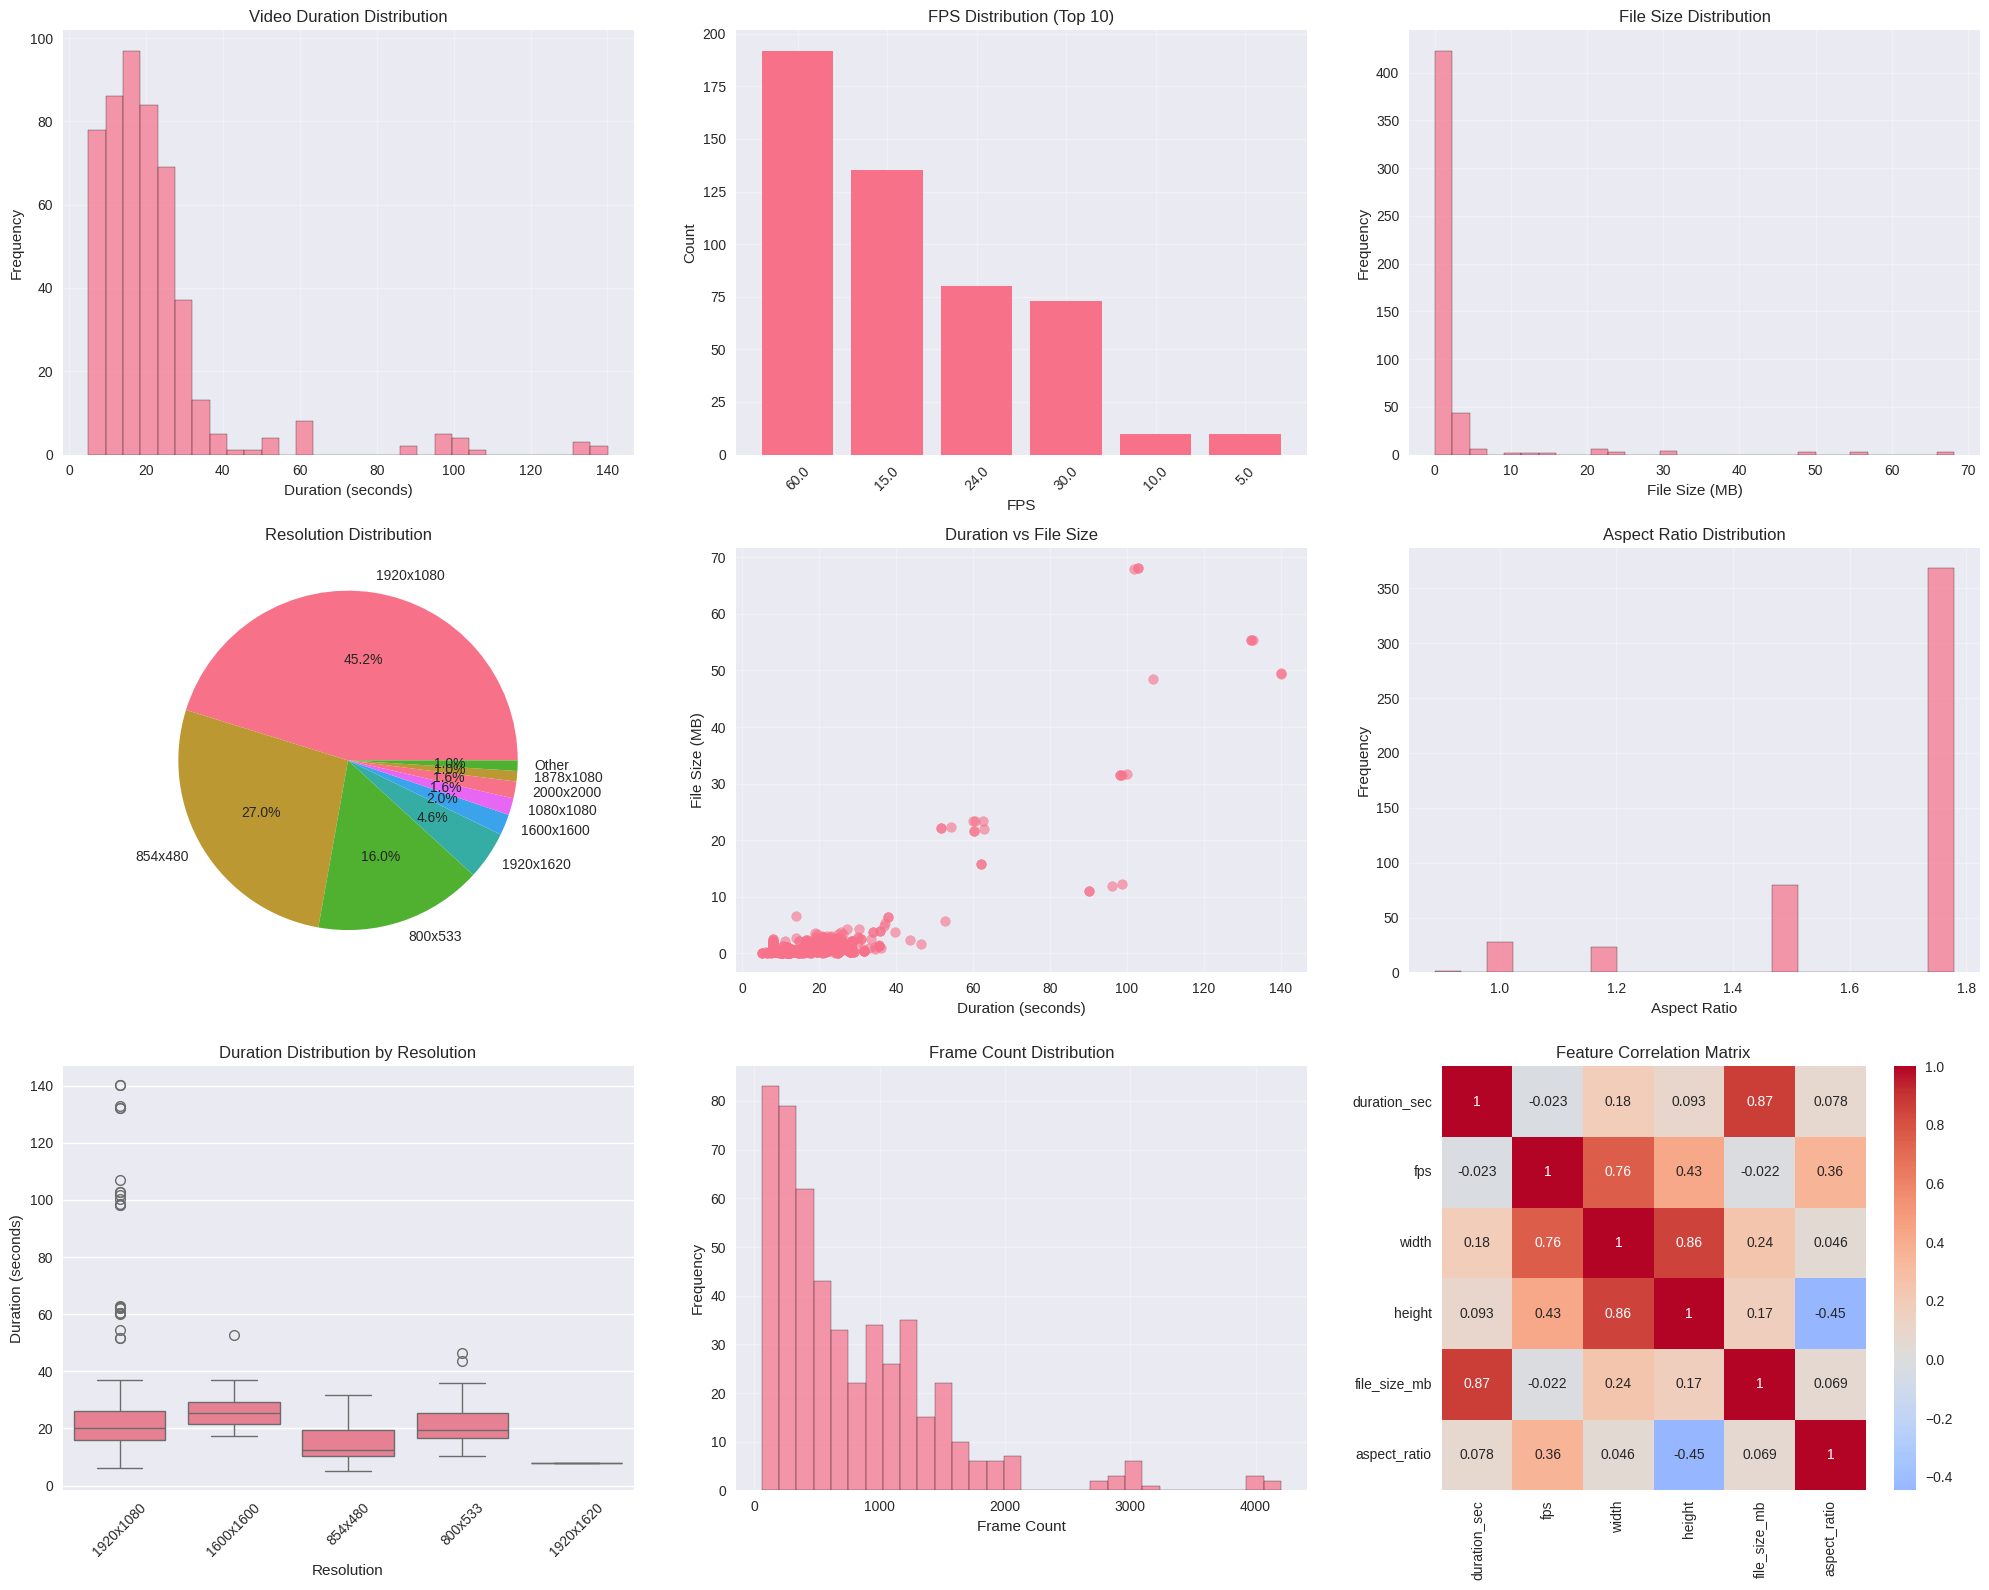

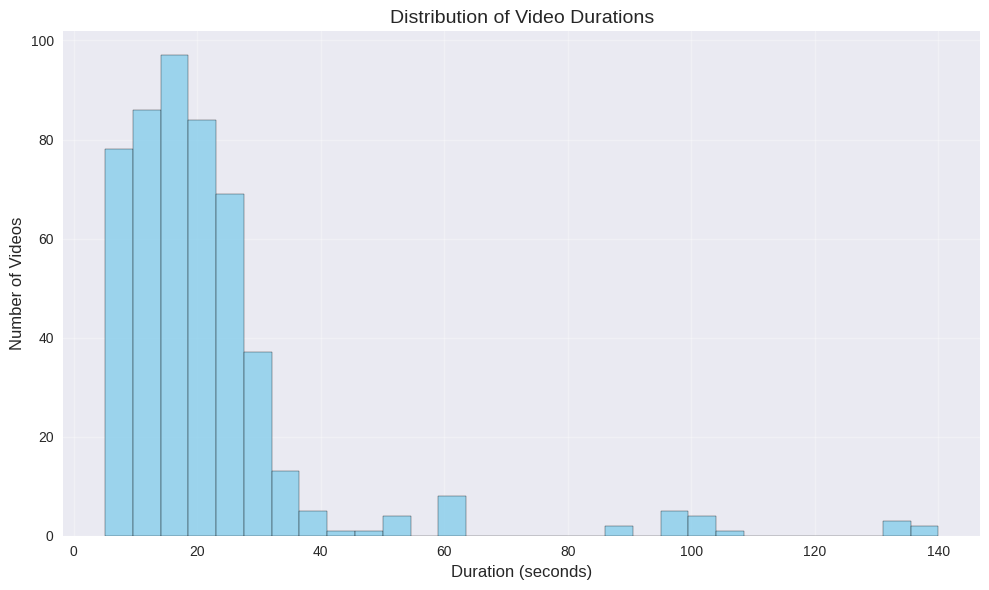

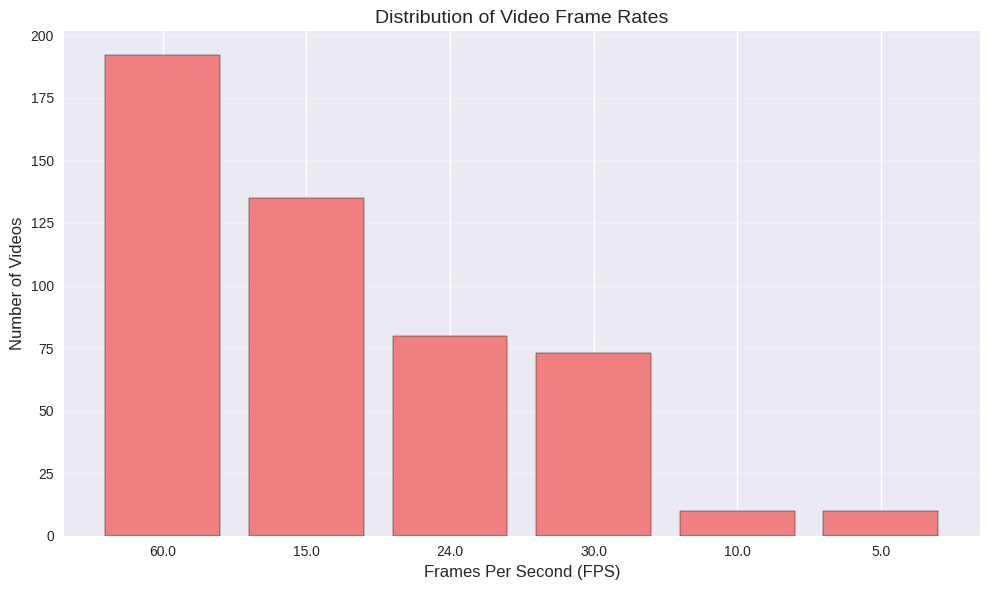

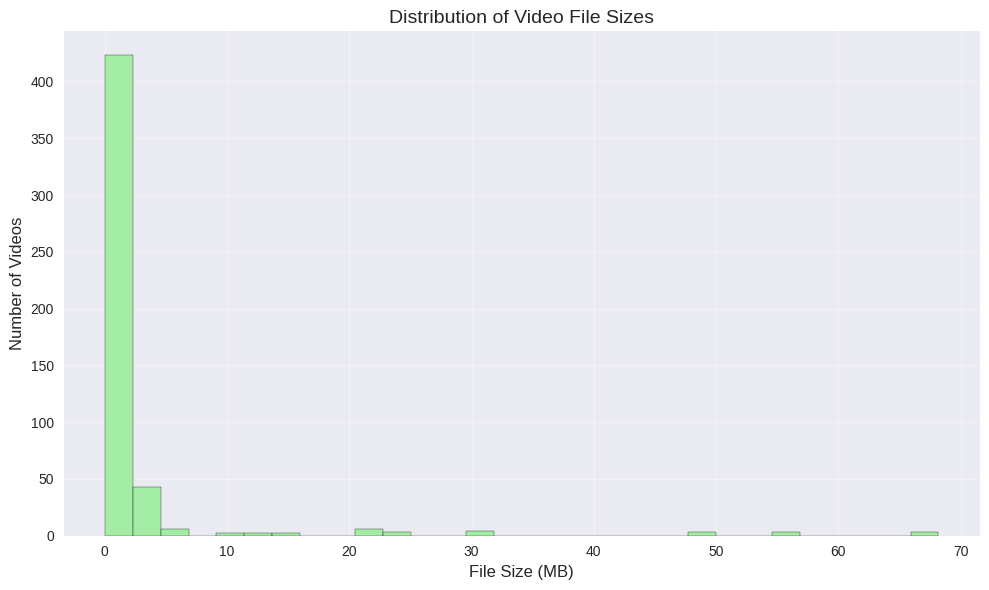

Statistics saved to video_statistics.json

Analysis complete! Check the 'figures' folder for visualizations.

Quick Summary:
Videos analyzed: 500
Average duration: 22.1 seconds
Most common FPS: 60.0
Most common resolution: 1920x1080


In [3]:
# Replace with your video folder path
VIDEO_FOLDER = "../../../hf_repo/test/"

# Run analysis
df_results, statistics = main(VIDEO_FOLDER)

# Optional: Print some quick stats
print(f"\nQuick Summary:")
print(f"Videos analyzed: {len(df_results)}")
print(f"Average duration: {df_results['duration_sec'].mean():.1f} seconds")
print(f"Most common FPS: {df_results['fps'].mode().iloc[0]:.1f}")
print(f"Most common resolution: {df_results['resolution'].mode().iloc[0]}")

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from matplotlib.backends.backend_pdf import PdfPages

def create_individual_pdf_plots(df, output_dir='figures_pdf'):
    """
    Create individual PDF plots for each visualization.
    """
    # Create output directory
    os.makedirs(output_dir, exist_ok=True)
    
    # Set style for publication-quality figures
    plt.style.use('seaborn-v0_8')
    sns.set_palette("husl")
    
    # Set default figure parameters for better PDF output
    plt.rcParams.update({
        'font.size': 15,
        'axes.titlesize': 24,
        'axes.labelsize': 24,
        'xtick.labelsize': 24,
        'ytick.labelsize': 24,
        'legend.fontsize': 12,
        'figure.titlesize': 16,
        'pdf.fonttype': 42,  # Ensure fonts are embedded properly
        'ps.fonttype': 42,
        'font.family': 'DejaVu Sans Mono',  #'serif',
        'font.style': 'normal',
        'font.weight': 'normal',
    })
    
    # 1. Duration Distribution
    plt.figure(figsize=(10, 6))
    plt.hist(df['duration_sec'], bins=30, alpha=0.8, edgecolor='black', color='skyblue')
    plt.xlabel('Duration (seconds)')
    plt.ylabel('Number of Videos')
    # plt.title('Distribution of Video Durations')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'{output_dir}/01_duration_distribution.pdf', 
                format='pdf', dpi=300, bbox_inches='tight')
    plt.close()
    
    # 2. FPS Distribution
    plt.figure(figsize=(10, 6))
    fps_counts = df['fps'].value_counts().head(10)
    bars = plt.bar(range(len(fps_counts)), fps_counts.values, 
                   color='lightcoral', edgecolor='black')
    plt.xlabel('Frames Per Second (FPS)')
    plt.ylabel('Number of Videos')
    # plt.title('Distribution of Video Frame Rates')
    plt.xticks(range(len(fps_counts)), [f'{fps:.1f}' for fps in fps_counts.index])
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.savefig(f'{output_dir}/02_fps_distribution.pdf', 
                format='pdf', dpi=300, bbox_inches='tight')
    plt.close()
    
    # 3. File Size Distribution
    plt.figure(figsize=(10, 6))
    plt.hist(df['file_size_mb'], bins=30, alpha=0.8, edgecolor='black', color='lightgreen')
    plt.xlabel('File Size (MB)')
    plt.ylabel('Number of Videos')
    plt.title('Distribution of Video File Sizes')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'{output_dir}/03_filesize_distribution.pdf', 
                format='pdf', dpi=300, bbox_inches='tight')
    plt.close()
    
    # 4. Resolution Distribution (Pie Chart)
    plt.figure(figsize=(10, 8))
    resolution_counts = df['resolution'].value_counts().head(8)
    other_count = df['resolution'].value_counts().iloc[8:].sum() if len(df['resolution'].value_counts()) > 8 else 0
    if other_count > 0:
        resolution_counts['Other'] = other_count
    
    colors = plt.cm.Set3(np.linspace(0, 1, len(resolution_counts)))
    plt.pie(resolution_counts.values, labels=resolution_counts.index, 
            autopct='%1.1f%%', colors=colors, startangle=90)
    # plt.title('Distribution of Video Resolutions')
    plt.axis('equal')
    plt.tight_layout()
    plt.savefig(f'{output_dir}/04_resolution_distribution.pdf', 
                format='pdf', dpi=300, bbox_inches='tight')
    plt.close()
    
    # 5. Duration vs File Size Scatter Plot
    plt.figure(figsize=(10, 6))
    plt.scatter(df['duration_sec'], df['file_size_mb'], alpha=0.6, color='purple')
    plt.xlabel('Duration (seconds)')
    plt.ylabel('File Size (MB)')
    plt.title('Duration vs File Size Relationship')
    plt.grid(True, alpha=0.3)
    
    # Add correlation coefficient to the plot
    correlation = df['duration_sec'].corr(df['file_size_mb'])
    plt.text(0.05, 0.95, f'Correlation: r = {correlation:.3f}', 
             transform=plt.gca().transAxes, bbox=dict(boxstyle="round", facecolor='wheat'))
    
    plt.tight_layout()
    plt.savefig(f'{output_dir}/05_duration_vs_filesize.pdf', 
                format='pdf', dpi=300, bbox_inches='tight')
    plt.close()
    
    # 6. Aspect Ratio Distribution
    plt.figure(figsize=(10, 6))
    plt.hist(df['aspect_ratio'], bins=20, alpha=0.8, edgecolor='black', color='orange')
    plt.xlabel('Aspect Ratio (Width/Height)')
    plt.ylabel('Number of Videos')
    plt.title('Distribution of Video Aspect Ratios')
    plt.grid(True, alpha=0.3)
    
    # Add vertical lines for common aspect ratios
    common_ratios = [16/9, 4/3, 1/1, 9/16]  # 16:9, 4:3, 1:1 (square), 9:16 (vertical)
    ratio_labels = ['16:9', '4:3', '1:1', '9:16']
    for ratio, label in zip(common_ratios, ratio_labels):
        plt.axvline(x=ratio, color='red', linestyle='--', alpha=0.7)
        plt.text(ratio, plt.ylim()[1]*0.9, label, rotation=90, 
                verticalalignment='top', horizontalalignment='right')
    
    plt.tight_layout()
    plt.savefig(f'{output_dir}/06_aspect_ratio_distribution.pdf', 
                format='pdf', dpi=300, bbox_inches='tight')
    plt.close()
    
    # 7. Box Plot for Duration by Common Resolutions
    plt.figure(figsize=(10, 6))
    top_resolutions = df['resolution'].value_counts().head(5).index
    df_top_res = df[df['resolution'].isin(top_resolutions)]
    
    sns.boxplot(data=df_top_res, x='resolution', y='duration_sec', palette='Set2')
    plt.xticks(rotation=15)
    plt.xlabel('Resolution')
    plt.ylabel('Duration (seconds)')
    # plt.title('Duration Distribution by Video Resolution')
    plt.tight_layout()
    plt.savefig(f'{output_dir}/07_duration_by_resolution.pdf', 
                format='pdf', dpi=300, bbox_inches='tight')
    plt.close()
    
    # 8. Frame Count Distribution
    plt.figure(figsize=(10, 6))
    plt.hist(df['frame_count'], bins=30, alpha=0.8, edgecolor='black', color='pink')
    plt.xlabel('Total Frame Count')
    plt.ylabel('Number of Videos')
    # plt.title('Distribution of Video Frame Counts')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'{output_dir}/08_frame_count_distribution.pdf', 
                format='pdf', dpi=300, bbox_inches='tight')
    plt.close()
    
    # 9. Correlation Heatmap
    plt.figure(figsize=(10, 8))
    numeric_cols = ['duration_sec', 'fps', 'width', 'height', 'file_size_mb', 'aspect_ratio']
    corr_matrix = df[numeric_cols].corr()
    
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  # Only show lower triangle
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
                square=True, fmt='.3f', cbar_kws={"shrink": .8})
    plt.title('Feature Correlation Matrix')
    plt.tight_layout()
    plt.savefig(f'{output_dir}/09_correlation_matrix.pdf', 
                format='pdf', dpi=300, bbox_inches='tight')
    plt.close()
    
    # 10. Summary Statistics Table as a figure
    plt.figure(figsize=(12, 8))
    
    # Create summary statistics
    stats_data = {
        'Metric': ['Duration (sec)', 'FPS', 'File Size (MB)', 'Width (px)', 'Height (px)', 'Aspect Ratio'],
        'Mean': [f"{df['duration_sec'].mean():.1f}", f"{df['fps'].mean():.1f}", 
                f"{df['file_size_mb'].mean():.1f}", f"{df['width'].mean():.0f}",
                f"{df['height'].mean():.0f}", f"{df['aspect_ratio'].mean():.2f}"],
        'Median': [f"{df['duration_sec'].median():.1f}", f"{df['fps'].median():.1f}",
                  f"{df['file_size_mb'].median():.1f}", f"{df['width'].median():.0f}",
                  f"{df['height'].median():.0f}", f"{df['aspect_ratio'].median():.2f}"],
        'Min': [f"{df['duration_sec'].min():.1f}", f"{df['fps'].min():.1f}",
               f"{df['file_size_mb'].min():.1f}", f"{df['width'].min():.0f}",
               f"{df['height'].min():.0f}", f"{df['aspect_ratio'].min():.2f}"],
        'Max': [f"{df['duration_sec'].max():.1f}", f"{df['fps'].max():.1f}",
               f"{df['file_size_mb'].max():.1f}", f"{df['width'].max():.0f}",
               f"{df['height'].max():.0f}", f"{df['aspect_ratio'].max():.2f}"],
        'Std': [f"{df['duration_sec'].std():.1f}", f"{df['fps'].std():.1f}",
               f"{df['file_size_mb'].std():.1f}", f"{df['width'].std():.0f}",
               f"{df['height'].std():.0f}", f"{df['aspect_ratio'].std():.2f}"]
    }
    
    # Create table
    table_data = []
    for i in range(len(stats_data['Metric'])):
        table_data.append([stats_data[col][i] for col in stats_data.keys()])
    
    plt.axis('tight')
    plt.axis('off')
    
    table = plt.table(cellText=table_data,
                     colLabels=list(stats_data.keys()),
                     cellLoc='center',
                     loc='center',
                     bbox=[0, 0, 1, 1])
    
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2)
    
    # Style the table
    for i in range(len(stats_data['Metric']) + 1):
        for j in range(len(stats_data.keys())):
            if i == 0:  # Header row
                table[(i, j)].set_facecolor('#40466e')
                table[(i, j)].set_text_props(weight='bold', color='white')
            else:
                table[(i, j)].set_facecolor('#f1f1f2')
    
    plt.title('Dataset Summary Statistics', fontsize=16, pad=20)
    plt.tight_layout()
    plt.savefig(f'{output_dir}/10_summary_statistics.pdf', 
                format='pdf', dpi=300, bbox_inches='tight')
    plt.close()
    
    print(f"All plots saved as individual PDF files in '{output_dir}' directory")
    print("Files created:")
    for i in range(1, 11):
        filename = [
            "01_duration_distribution.pdf",
            "02_fps_distribution.pdf", 
            "03_filesize_distribution.pdf",
            "04_resolution_distribution.pdf",
            "05_duration_vs_filesize.pdf",
            "06_aspect_ratio_distribution.pdf",
            "07_duration_by_resolution.pdf",
            "08_frame_count_distribution.pdf",
            "09_correlation_matrix.pdf",
            "10_summary_statistics.pdf"
        ][i-1]
        print(f"  - {filename}")

def create_multi_page_pdf(df, output_file='video_analysis_complete.pdf'):
    """
    Create a single multi-page PDF with all plots.
    """
    with PdfPages(output_file) as pdf:
        # Set style
        plt.style.use('seaborn-v0_8')
        sns.set_palette("husl")
        
        # Page 1: Duration Distribution
        fig = plt.figure(figsize=(10, 6))
        plt.hist(df['duration_sec'], bins=30, alpha=0.8, edgecolor='black', color='skyblue')
        plt.xlabel('Duration (seconds)')
        plt.ylabel('Number of Videos')
        plt.title('Distribution of Video Durations')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        pdf.savefig(fig, bbox_inches='tight')
        plt.close()
        
        # Page 2: FPS Distribution
        fig = plt.figure(figsize=(10, 6))
        fps_counts = df['fps'].value_counts().head(10)
        plt.bar(range(len(fps_counts)), fps_counts.values, 
               color='lightcoral', edgecolor='black')
        plt.xlabel('Frames Per Second (FPS)')
        plt.ylabel('Number of Videos')
        plt.title('Distribution of Video Frame Rates')
        plt.xticks(range(len(fps_counts)), [f'{fps:.1f}' for fps in fps_counts.index])
        plt.grid(True, alpha=0.3, axis='y')
        plt.tight_layout()
        pdf.savefig(fig, bbox_inches='tight')
        plt.close()
        
        # Add more pages as needed...
        # (Similar pattern for other plots)
        
    print(f"Multi-page PDF saved as: {output_file}")

In [26]:
# Assuming you have your DataFrame 'df' from the main analysis
df = pd.read_csv('video_analysis_raw_data.csv')
create_individual_pdf_plots(df)
create_multi_page_pdf(df)

/tmp/ipykernel_730150/4005325683.py:134: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_top_res, x='resolution', y='duration_sec', palette='Set2')


All plots saved as individual PDF files in 'figures_pdf' directory
Files created:
  - 01_duration_distribution.pdf
  - 02_fps_distribution.pdf
  - 03_filesize_distribution.pdf
  - 04_resolution_distribution.pdf
  - 05_duration_vs_filesize.pdf
  - 06_aspect_ratio_distribution.pdf
  - 07_duration_by_resolution.pdf
  - 08_frame_count_distribution.pdf
  - 09_correlation_matrix.pdf
  - 10_summary_statistics.pdf
Multi-page PDF saved as: video_analysis_complete.pdf
